Import some libraries we'll use:

In [26]:
import urllib.request
import gzip
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import rasterio as rio
from pyproj import Proj, transform
from scipy.spatial import cKDTree  

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

# Get NOAA weather stations

First, let's get the [list of NOAA weather stations](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt) so that we have a lat/lon location for each:

In [2]:
file = 'ghcnd-stations.txt'

if os.path.isfile(file):
    print('Stations already downloaded, using local file.')
else:
    print('Using online stations file directly.')
    file = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'

# we are using 100000 rows here to let pandas figure out the column widths - this is a bit slower, 
# but makes sure that we get all the stations way out west or south correctly without chopping of the minus sign 
stations = pd.read_fwf(file, 
            infer_nrows=100000, # how many rows to use to infer the column widths
            usecols = [0,1,2,3,5],
            names = ["station", "lat", "lon", "elevation", "name"])

stations.head()

Stations already downloaded, using local file.


,station,lat,lon,elevation,name
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL


Check the range of the lat and lon columns to make sure the coordinates have been parsed correctly:

In [3]:
print(f'Lats go from {stations.lat.min()} to {stations.lat.max()}')
print(f'Lons go from {stations.lon.min()} to {stations.lon.max()}')

Lats go from -90.0 to 83.65
Lons go from -179.983 to 179.32


Pull out the country ID from the station column (first two letters):

In [4]:
stations["country"] = stations["station"].astype(str).str[0:2]
stations.head()

,station,lat,lon,elevation,name,country
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE


Since the GHSL data we'll be using later is in Mollweide projection, we'll need to [project](https://github.com/pyproj4/pyproj) the lat/lon to the World Mollweide projection that the raster uses and pick up the values at those projected coordinates:

In [5]:
inProj = Proj(init='epsg:4326')   # lat/lon 
outProj = Proj('+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs', preserve_flags=True) # Mollweide

projectedLocations = []

# go through the list of stations and project each one to Mollweide
for index, station in stations.iterrows():
    projectedLocations.append((transform(inProj,outProj,station['lon'],station['lat'])))

# add the projected coordinates back to the stations dataframe
stations['mollX'], stations['mollY'] = zip(*projectedLocations)
stations.head()

,station,lat,lon,elevation,name,country,mollX,mollY
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06


# Get [GHSL population data](https://ghsl.jrc.ec.europa.eu/ghs_pop.php) for 1975

Download dir at http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/

In [6]:
file = 'GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.tif'

if os.path.isfile(file):
    print('GHSL population data for 1975 already downloaded.')
else:
    url = 'http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/GHS_POP_GPW41975_GLOBE_R2015A_54009_250/V1-0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.zip'
    urllib.request.urlretrieve(url, file)
    
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    
    # remove the ZIP file and the extracted overview file - we don't need it and the .ovr file is huge (3GB!)
    os.remove('GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.zip')
    os.remove('GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.tif.ovr')

GHSL population data for 1975 already downloaded.


We'll use the data to assign each station an estimate of the population density in the GHSL cell that it is in. Since GHSL is in an equal area projection (i.e. all cells have the same area), we can safely do that.

We'll use [rasterio's sample method](https://gis.stackexchange.com/questions/190423/getting-pixel-values-at-single-point-using-rasterio) for that. Let's read in the GeoTIFF first:

In [7]:
pop1975 = rio.open(file)
pop1975

<open DatasetReader name='GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.tif' mode='r'>

In [8]:
pop1975.bounds

BoundingBox(left=-17619594.54744353, bottom=-6484970.538131511, right=17877405.45255647, top=8750529.46186849)

In [9]:
pop1975.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 141988,
 'height': 60942,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Mollweide"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]'),
 'transform': Affine(250.0, 0.0, -17619594.54744353,
        0.0, -250.0, 8750529.46186849)}

To get values at point locations, we can simply pass a list of ```(x,y)``` tuples and rasterio will return a list of values at those points:

In [10]:
for val in pop1975.sample([(8432553,2759349)]):
    print(val)

[2680.5662]


Check that all coordinates are in the raster's bounding box:

In [11]:
print(min(stations['mollX']) > pop1975.bounds.left)
print(max(stations['mollX']) < pop1975.bounds.right)

print(min(stations['mollY']) > pop1975.bounds.bottom)
print(max(stations['mollY']) < pop1975.bounds.top)

True
True
False
False


Okay, so there are some stations North and South of our raster. Export to CSV to take a look in QGIS:

In [12]:
stations.to_csv('stations_moll.csv')

Remove the stations that are outside of our raster bounding box (they are not really useful for our UHI analysis anyway, and [rasterio seems trip over them](https://gis.stackexchange.com/questions/323481/error-using-rasterios-sample-method)):

In [13]:
print(f'Before removal: {len(stations.index)} stations.')
stations = stations.drop(stations[stations['mollY'] < pop1975.bounds.bottom].index)
stations = stations.drop(stations[stations['mollY'] > pop1975.bounds.top].index)
print(f'After removal: {len(stations.index)} stations.')

Before removal: 113951 stations.
After removal: 113848 stations.


In [14]:
stations.to_csv('stations_moll_inraster.csv')

Now we can use those remaining station locations to sample the raster:

In [15]:
locations = list(zip(stations['mollX'], stations['mollY']))
pop1975col = []

for val in pop1975.sample(locations):
    pop1975col.append(val[0])

# make this list a new column in our stations dataframe
stations['pop1975'] = pop1975col
stations.to_csv('stations_moll_inraster_pop1975.csv')
stations.head()

,station,lat,lon,elevation,name,country,mollX,mollY,pop1975
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,2.571450
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,21.834427


# Stats

Some stats about the frequencies, i.e. how many stations do we have in densely populated areas? First, we'll make a log-scale histogram that shows population at the cell where the station is in people per 250mx250m cell:

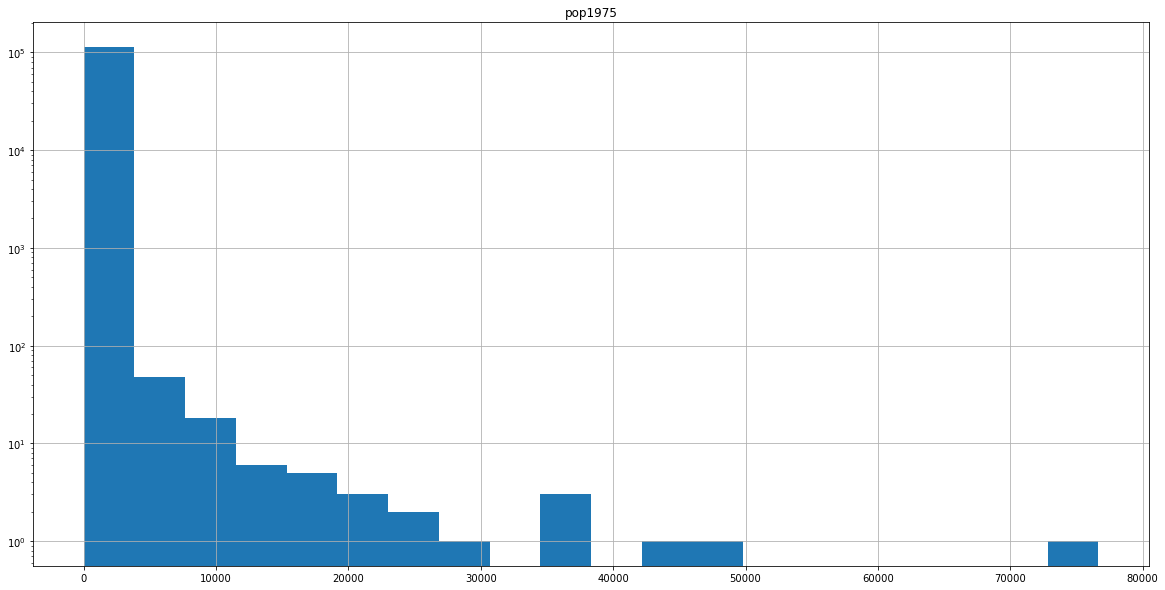

In [39]:
fig, ax = plt.subplots()
stations.hist(ax=ax, bins=20, column='pop1975')
ax.set_yscale('log')

Some of these are in crazy densely populated areas! Let's check which ones they are (top 10):

In [42]:
stations.nlargest(10, 'pop1975')

,station,lat,lon,elevation,name,country,mollX,mollY,pop1975
37284,IN009182200,14.380,75.250,595.0,SHIRALKOPPA,IN,7.394993e+06,1.770848e+06,76649.007812
38151,IN017042300,20.380,85.530,48.0,BANKI BANKIGARH,IN,8.236382e+06,2.499446e+06,48236.531250
39097,IN023130500,28.070,78.750,168.0,SAHASWAN,IN,7.304260e+06,3.417123e+06,45201.609375
38350,IN019021101,28.030,76.720,249.0,KOTKASIM,IN,7.117617e+06,3.412407e+06,36997.242188
39162,IN023250700,27.133,81.967,110.0,GONDA,IN,7.643118e+06,3.306482e+06,36071.953125
39252,IN023401000,28.620,78.800,244.0,BILARI,IN,7.285425e+06,3.481898e+06,35648.445312
39314,IN023500300,27.430,80.530,137.0,MISRIKH,IN,7.496670e+06,3.341590e+06,28040.953125
39311,IN023500100,27.570,80.680,136.0,SITAPUR,IN,7.504704e+06,3.358128e+06,24886.984375
38922,IN020130200,11.150,78.600,137.0,TURAIYUR,IN,7.785403e+06,1.375303e+06,23618.195312
39443,IN024119900,21.780,87.750,8.0,CONTAI,IN,8.401021e+06,2.668028e+06,22441.925781


They're all in India, what about the US?

In [43]:
stations[stations.country == 'US'].nlargest(10, 'pop1975')

,station,lat,lon,elevation,name,country,mollX,mollY,pop1975
99096,USC00305806,40.8500,-73.9167,54.9,NEW YORK UNIV ST,US,-6.228115e+06,4.884185e+06,3317.0
67194,US1LASB0001,29.9313,-89.9308,1.2,MERAUX 0.8 WNW,US,-8.248478e+06,3.635811e+06,2747.0
93300,USC00166130,29.9314,-89.9305,1.2,MERAUX,US,-8.248446e+06,3.635822e+06,2747.0
75357,US1NYQN0026,40.7544,-73.8882,18.0,JACKSON HEIGHTS 0.3 WSW,US,-6.231330e+06,4.873547e+06,2338.0
75243,US1NYNY0074,40.7969,-73.9330,6.1,NEW YORK 8.8 N,US,-6.232612e+06,4.878277e+06,1815.0
63121,US1ILCK0097,41.9301,-87.6393,180.1,CHICAGO 6.8 NNE,US,-7.307915e+06,5.003975e+06,1695.0
75818,US1OHFR0048,39.9946,-83.0131,232.3,COLUMBUS 1.4 WNW,US,-7.050456e+06,4.788796e+06,1644.0
99128,USC00306301,41.1500,-73.8667,9.1,OSSINING SING SING,US,-6.206189e+06,4.917532e+06,1454.0
75929,US1OHLK0004,41.6032,-81.4435,242.0,WILLOUGHBY HILLS 1.3 NNW,US,-6.812985e+06,4.967798e+06,1449.0
63087,US1ILCK0036,41.8860,-87.6210,191.1,CHICAGO 4.7 NE,US,-7.309552e+06,4.999098e+06,1401.0


Okay, so we have at least some stations in urban areas. The plan is now to see whether these have systematically higher temperatures than their nun-urban neighbor stations. Before we get into that, we'll need to make some more preparations:

# Spatial Index

Next, we'll build a spatial index of the stations, so we can quickly look up the nearest neighbors of any station. We'll be using the [scipy.spatial.cKDTree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html) (based on [this hint](https://gis.stackexchange.com/a/301935/33224).). For that, we'll pull out just the Mollweide coordinates and build the index based on those (otherwise SciPy will make a multidimensional index using all columns):

In [47]:
stationsIndex = cKDTree(stations[['mollX','mollY']].values)

Let's try to find the closest stations to a specific one by name:

In [48]:
def queryStation(stationID, stations, stationsIndex, k=1):
    queryCoords = stations[stations.station==stationID][['mollX','mollY']].values
    dd, ii = stationsIndex.query(queryCoords, 
                             k=range(2,2+k), # start at 2, otherwise we get the station itself as first result
                             n_jobs=-1)      # use all CPUs
    knn = stations.iloc[ii[0]]
    knn = knn.copy()  # otherwise we might be modifying the stations dataframe...
    knn['distance'] = dd[0]
    return knn

Test:

In [49]:
stationID = 'RQC00663871'   # GARZAS station
queryStation(stationID, stations, stationsIndex, k=5)

,station,lat,lon,elevation,name,country,mollX,mollY,pop1975,distance
47206,RQC00660053,18.1614,-66.7222,506.0,ADJUNTAS 1 S,RQ,-6.479289e+06,2.231113e+06,96.454247,1924.820868
47331,RQC00668684,18.1333,-66.7333,868.7,SALTILLO 2 ADJUNTAS,RQ,-6.481011e+06,2.227706e+06,8.375000,2060.888936
47266,RQC00664614,18.1506,-66.7719,2.7,HUMACAO NATURAL RESERVE,RQ,-6.484363e+06,2.229804e+06,0.000000,3735.475164
47207,RQC00660061,18.1747,-66.7978,557.8,ADJUNTAS SUBSTN,RQ,-6.486324e+06,2.232726e+06,0.000000,6435.610695
47309,RQC00666982,18.0833,-66.7333,349.9,PENUELAS SALTO GARZAS,RQ,-6.482155e+06,2.221642e+06,12.000000,8231.252200


# Get NOAA NCDC data

Download the data from NOAA. The columns in the file are documented [here](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/readme.txt).

In [50]:
file = '1975.csv.gz'
if os.path.isfile(file):
    print(file, 'already downloaded.')
else:
    urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/1975.csv.gz', file)

1975.csv.gz already downloaded.


Before we can read the file, we'll define our own date parser:

In [51]:
noaadateparser = lambda x: pd.datetime.strptime(x, "%Y%m%d")


Unzip the file and load the CSV with pandas, using our date parser. We'll also give the columns names since the CSV doesn't have a header 🧟‍:

In [ ]:
with gzip.open('1975.csv.gz') as f:

    data_1975 = pd.read_csv(f, 
                            names = ["station", "date", "type", "value"],
                            usecols = [0,1,2,3],
                            parse_dates = ["date"],
                            date_parser = noaadateparser)

data_1975.head()

In [ ]:
data_1975.dtypes

Only keep TMIN and TMAX: (🔥 ToDo: Here we may want to keep precipitation/snowfall in the future, since the decrease in temperature with increasing elevation depends )

In [ ]:
data_1975 = data_1975[(data_1975["type"] == "TMAX") | (data_1975["type"] == "TMIN")] 

In [ ]:
data_1975.head

Join the two together:

In [ ]:
data_1975 = pd.merge(data_1975, stations, on="station")
data_1975.head()



Index the dataframe by country, station, date and observation type:

In [ ]:
data_1975.set_index(['country','station','date','type'], inplace=True)
data_1975.head()

In [ ]:
data_1975.loc['US']